# Датасет


Ссылка на датасет: https://www.kaggle.com/datasets/thedevastator/global-video-game-sales-and-reviews
Датасет "Video Games Sales.csv" содержит информацию о продажах видеоигр. Он включает рейтинг, региональные продажи, названия, жанры, издателей, платформы, отзывы и год выпуска. Данные предоставляют обширный обзор индустрии видеоигр, подходят для анализа трендов и проведения исследований.

В качестве задачи классификации я обучаю модель на предсказание года выпуска игры исходя из жанра и количества проданных единиц в разных регионах.

## Реализация

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Реализация логистической регрессии с использованием метода градиентного спуска.

In [26]:
class MyLogisticRegression():
    def __init__(self, learning_rate=0.1, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        num_classes = len(np.unique(y))
        num_features = X.shape[1]

        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros((1, num_classes))

        y_one_hot = np.eye(num_classes)[y]

        for _ in range(self.num_iterations):
            linear_combination = np.dot(X, self.weights) + self.bias

            predictions = self.softmax(linear_combination)

            gradient_weights = np.dot(X.T, (predictions - y_one_hot)) / len(y)
            gradient_bias = np.sum(predictions - y_one_hot, axis=0, keepdims=True) / len(y)

            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias

    def predict(self, X):
        linear_combination = np.dot(X, self.weights) + self.bias
        predictions = self.softmax(linear_combination)
        return np.argmax(predictions, axis=1)

Реализация дерева решений с возможностью задать максимальную глубину. 

In [27]:
class MyDecisionTreeClassifier():
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        unique_classes = list(set(y))

        if len(unique_classes) == 1:
            return {'class': unique_classes[0]}

        if self.max_depth is not None and depth == self.max_depth:
            most_common_class = max(set(y))
            return {'class': most_common_class}

        best_split = self._find_best_split(X, y)

        if best_split is None:
            print(type(y))
            most_common_class = max(set(y))
            return {'class': most_common_class}

        left_child = self._build_tree(*best_split['left'], depth=depth + 1)
        right_child = self._build_tree(*best_split['right'], depth=depth + 1)

        return {'feature_idx': best_split['feature_idx'],
                'threshold': best_split['threshold'],
                'left': left_child,
                'right': right_child}

    def _find_best_split(self, X, y):
        num_features = len(X[0])
        m = len(y)
        if m <= 1:
            return None

        num_classes = len(set(y))

        best_gini = float('inf')
        best_split = None

        for feature_idx in range(num_features):
            feature_values = sorted(set(X[i][feature_idx] for i in range(m)))

            for threshold in feature_values:
                left_indices = [i for i in range(m) if X[i][feature_idx] <= threshold]
                right_indices = [i for i in range(m) if X[i][feature_idx] > threshold]

                gini_left = self._compute_gini(y[left_indices])
                gini_right = self._compute_gini(y[right_indices])

                weighted_gini = (len(left_indices) / m) * gini_left + (len(right_indices) / m) * gini_right

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = {'feature_idx': feature_idx, 'threshold': threshold, 'left': (X[left_indices], y[left_indices]), 'right': (X[right_indices], y[right_indices])}

        return best_split

    def _compute_gini(self, y):
        m = len(y)
        if m == 0:
            return 0

        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / m
        gini = 1 - np.sum(probabilities ** 2)

        return gini

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if 'class' in node:
            return node['class']

        if x[node['feature_idx']] <= node['threshold']:
            return self._predict_tree(x, node['left'])
        else:
            return self._predict_tree(x, node['right'])

Класс, представляющий случайный лес, который использует несколько деревьев решений.

In [28]:
class MyRandomForestClassifier():
    def __init__(self, n_trees=10, max_depth=None, sample_size=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.sample_size = sample_size
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth)
            if self.sample_size:
                sample_indices = np.random.choice(len(X), size=self.sample_size, replace=True)
                X_sample, y_sample = X[sample_indices], y[sample_indices]
            else:
                X_sample, y_sample = X, y
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)


Реализация градиентного бустинга с возможностью задать количество деревьев, learning rate и максимальную глубину.

In [29]:
class MyGradientBoostingClassifier():
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        predictions = np.zeros_like(y, dtype=np.float64)

        for i in range(self.n_estimators):
            residuals = y - predictions

            tree = MyDecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(X, residuals)

            tree_predictions = tree.predict(X)

            predictions += (self.learning_rate * tree_predictions)

            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions

## Данные

In [31]:
data = pd.read_csv('./VideoGamesSales.csv')
numeric_cols = data.select_dtypes(include=['number']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data["Year"] = data["Year"].astype(int)
data.head()

,index,Rank,Game Title,Platform,Year,Genre,Publisher,North America,Europe,Japan,Rest of World,Global,Review
0,0,1,Wii Sports,Wii,2006,Sports,Nintendo,40.43,28.39,3.77,8.54,81.12,76.28
1,1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,91.00
2,2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,14.50,12.22,3.63,3.21,33.55,82.07
3,3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,14.82,10.51,3.18,3.01,31.52,82.65
4,4,5,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,88.00


### Разделим на категории и будем решать задачу классификации по жанрам

In [32]:
num_cols = [
    'Rank',              # Ранг видеоигры по глобальным продажам
    'Europe',            # Количество проданных единиц в Европе (в миллионах)
    'Japan',             # Количество проданных единиц в Японии (в миллионах)
    'Rest of World',     # Предполагается, что есть столбец 'Rest of World', но не определен в предоставленных данных
    'North America',     # Количество проданных единиц в Северной Америке (в миллионах)
    'Review'             # Предполагается, что есть столбец 'Review', но не определен в предоставленных данных
]

cat_cols = [
    'Genre'              # Жанр игры, например, экшн, приключения, гонки и т. д.
]

target_col = 'Year'      # Год выпуска игры

cols = num_cols + cat_cols + [target_col]

In [33]:
data = data[cols]
data.head()

,Rank,Europe,Japan,Rest of World,North America,Review,Genre,Year
0,1,28.39,3.77,8.54,40.43,76.28,Sports,2006
1,2,3.58,6.81,0.77,29.08,91.00,Platform,1985
2,3,12.22,3.63,3.21,14.50,82.07,Racing,2008
3,4,10.51,3.18,3.01,14.82,82.65,Sports,2009
4,5,2.26,4.22,0.58,23.20,88.00,Puzzle,1989


### Обучим на неподготовленных данных

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[num_cols].values, data[target_col].values, test_size=0.2)

In [35]:
from sklearn.preprocessing import MinMaxScaler

pca = MinMaxScaler()
pca.fit(X_train)
X_train = pca.transform(X_train)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score, mean_squared_error

Функция для вывода метрик:
1. Коэффициент детерминации (R^2)
2. Среднеквадратическая ошибка (MSE)

In [38]:
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

In [ ]:
dr = DummyClassifier()
dr.fit(X_train, y_train)
print_metrics(dr.predict(X_test), y_test)

R^2: 0.0
MSE: 86.76666666666667


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_test), y_test)

R^2: -0.6468703194120311
MSE: 52.53333333333333


In [ ]:
lr = MyLogisticRegression()
lr.fit(X_train, y_train - np.min(data['Year']))

print_metrics(lr.predict(X_test), y_test- np.min(data['Year']))

R^2: -0.9519304661207832
MSE: 61.38333333333333


array([[<Axes: title={'center': 'Rank'}>,
        <Axes: title={'center': 'Europe'}>,
        <Axes: title={'center': 'Japan'}>],
       [<Axes: title={'center': 'Rest of World'}>,
        <Axes: title={'center': 'North America'}>,
        <Axes: title={'center': 'Review'}>],
       [<Axes: title={'center': 'Year'}>, <Axes: >, <Axes: >]],
      dtype=object)

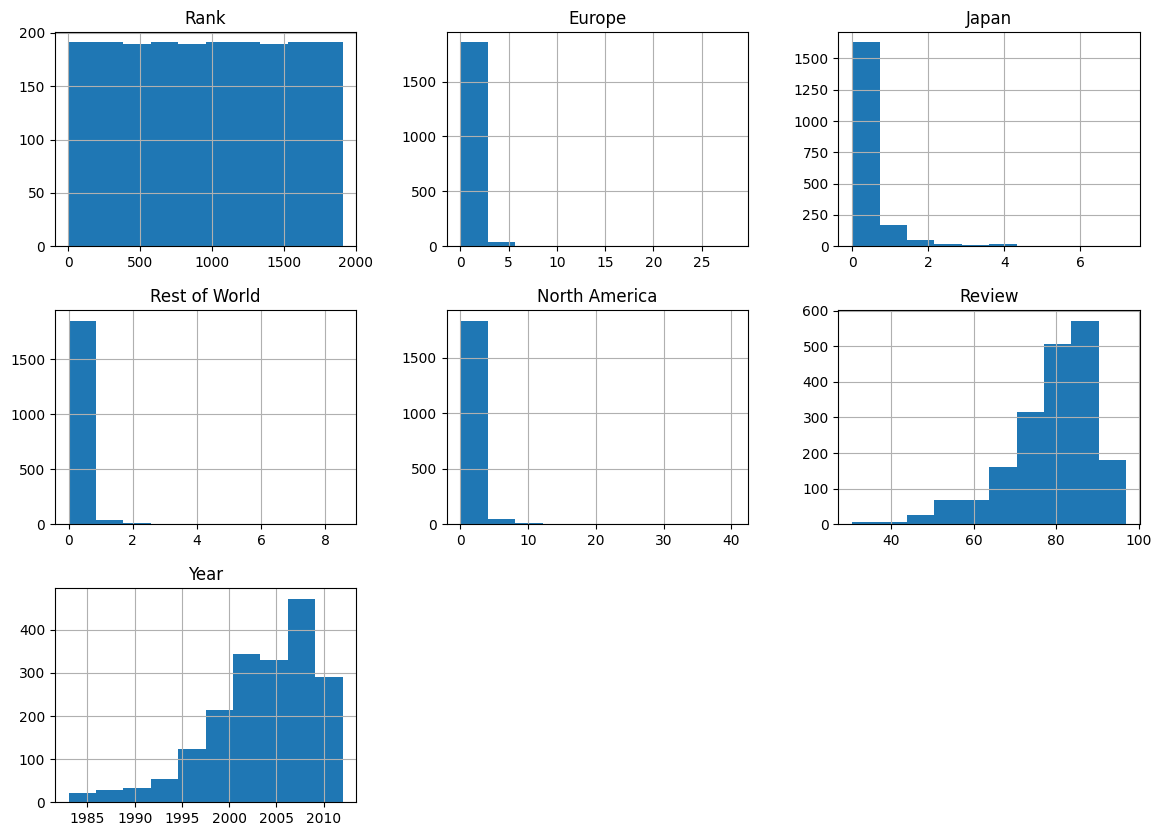

In [42]:
data.hist(column=num_cols+cat_cols+[target_col], figsize=(14, 10))

Добавляю в датафрейм колонки для всех категориальных столбцов

In [43]:
cat_genre = data['Genre']
cat_genre = pd.get_dummies(cat_genre)
data = data.drop(columns=['Genre'])
cat_cols.remove('Genre')

data = data.join(cat_genre)
cat_cols.extend(list(cat_genre.columns))
cat_cols

['Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy']

### Обучим на подготовленных данных

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[num_cols + cat_cols].values, data[target_col].values, test_size=0.2)

In [45]:
from sklearn.preprocessing import MinMaxScaler

pca = MinMaxScaler()
pca.fit(X_train)
X_train = pca.transform(X_train)

### Константный предиктор

In [ ]:
dr = DummyClassifier()
dr.fit(X_train, y_train)

print_metrics(dr.predict(X_test), y_test)

R^2: 0.0
MSE: 59.21666666666667


### Логистическая регрессия

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_test), y_test)

R^2: 0.7437520757223512
MSE: 13.716666666666667


In [ ]:
lr = MyLogisticRegression()
lr.fit(X_train, y_train - np.min(data['Year']))

print_metrics(lr.predict(X_test), y_test - np.min(data['Year']))

R^2: 0.6242977700666965
MSE: 21.233333333333334


### Дерево решений

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

print_metrics(dtc.predict(X_test), y_test)

R^2: 0.9118880202646634
MSE: 4.483333333333333


In [ ]:
dtc = MyDecisionTreeClassifier()
dtc.fit(X_train, y_train)
print_metrics(dtc.predict(X_test), y_test)

R^2: 0.8895211350872007
MSE: 4.983333333333333


### Случайный лес

In [ ]:
dtc = RandomForestClassifier(n_estimators=500, min_samples_split=30)
dtc.fit(X_train, y_train)

print_metrics(dtc.predict(X_test), y_test)

R^2: 0.838997251027138
MSE: 7.5


In [ ]:
dtc = MyRandomForestClassifier()
dtc.fit(X_train, y_train)

print_metrics(dtc.predict(X_test), y_test)

R^2: 0.8895211350872007
MSE: 4.983333333333333


### Градиентный бустинг

In [ ]:
dtc = GradientBoostingClassifier()
dtc.fit(X_train, y_train)

print_metrics(dtc.predict(X_test), y_test)

R^2: 0.9619407764325577
MSE: 1.7333333333333334


In [ ]:
dtc = MyGradientBoostingClassifier(learning_rate=0.5)
dtc.fit(X_train, y_train)
print_metrics(dtc.predict(X_test), y_test)

R^2: 0.8369485195395476
MSE: 8.518405707682698
